# Proyek Klasifikasi Gambar: [Intel Image Classification]
- **Nama:** [MUHAMMAD AGUSRIANSYAH]
- **Email:** [mc224d5y1338@student.devacademy.id]
- **ID Dicoding:** [MC224D5Y1338]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
import pathlib
import seaborn as sns
import pandas as pd


## Data Preparation

### Data Loading

In [2]:
# Dataset dari KaggleHub
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

# Path ke folder 'seg_train/seg_train'
data_dir = pathlib.Path(dataset_path) / "seg_train" / "seg_train"

# Isi folder kelas
print("Isi folder kelas di seg_train:", os.listdir(data_dir))

Isi folder kelas di seg_train: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


<ipython-input-3-d5dd1f282b52>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=distribution_train, x='labels', palette='Set2')


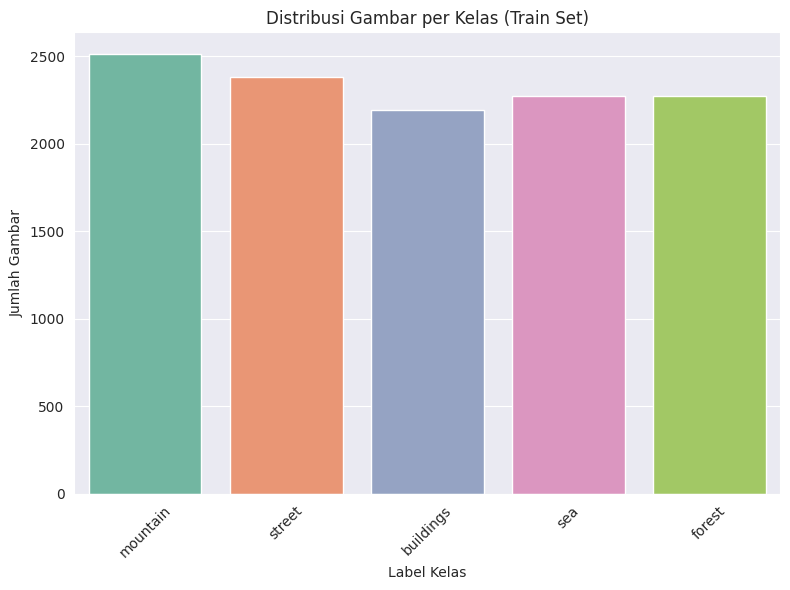

In [3]:
# Path ke folder dataset
intel_path = os.path.join(dataset_path, "seg_train", "seg_train")

# 5 kelas yang digunakan
classes_to_use = ['mountain', 'buildings', 'sea', 'forest', 'street']

# List kosong untuk menyimpan hasil filter
file_name = []
labels = []
full_path = []

# Baca seluruh file dan filter kelas yang dipilih
for path, _, files in os.walk(intel_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            class_name = os.path.basename(path)
            if class_name in classes_to_use:
                file_path = os.path.join(path, name)
                full_path.append(file_path)
                labels.append(class_name)
                file_name.append(name)

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi kelas
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_train, x='labels', palette='Set2')
plt.title("Distribusi Gambar per Kelas (Train Set)")
plt.xlabel("Label Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Data Preprocessing

#### Split Dataset

In [4]:
# Setting parameter dasar
batch_size = 64
img_height = 224
img_width = 224
seed = 123

In [5]:
# Membuat train dataset (70%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 30% dibagi untuk validasi dan test
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.


In [6]:
# Class names dari salah satu subset
class_names = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
).class_names

Found 14034 files belonging to 6 classes.
Using 4210 files for validation.


In [7]:
# Membuat validation dataset (30%)
val_ds_full = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 4210 files for validation.


In [8]:
# Bagi val_ds_full menjadi val_ds dan test_ds
val_batches = tf.data.experimental.cardinality(val_ds_full)
test_ds = val_ds_full.take(val_batches // 2)
val_ds = val_ds_full.skip(val_batches // 2)

In [9]:
# Menampilkan jumlah batch
print(f"Jumlah batch di training set: {tf.data.experimental.cardinality(train_ds)}")
print(f"Jumlah batch di validation set: {tf.data.experimental.cardinality(val_ds)}")
print(f"Jumlah batch di test set: {tf.data.experimental.cardinality(test_ds)}")

Jumlah batch di training set: 154
Jumlah batch di validation set: 33
Jumlah batch di test set: 33


In [10]:
# Normalisasi
normalization_layer = layers.Rescaling(1./255)

# Augmentasi (hanya untuk train)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Terapkan ke dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Modelling

In [11]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv block 5
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


In [12]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,194,502 (16.00 MB)

 Trainable params: 4,193,030 (16.00 MB)

 Non-trainable params: 1,472 (5.75 KB)

### Setup Callback

In [13]:
# Callback untuk menghentikan training jika tidak membaik
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [14]:
# Callback untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',         # Simpan model ke file ini
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Tambahkan ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

### Training Model

In [16]:
# Latih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, checkpoint, lr_reduction]
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.5199 - loss: 1.5182
Epoch 1: val_accuracy improved from -inf to 0.19876, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 167s 964ms/step - accuracy: 0.5203 - loss: 1.5162 - val_accuracy: 0.1988 - val_loss: 4.9422 - learning_rate: 1.0000e-04
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.6576 - loss: 0.9247
Epoch 2: val_accuracy improved from 0.19876 to 0.22593, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 812ms/step - accuracy: 0.6577 - loss: 0.9245 - val_accuracy: 0.2259 - val_loss: 3.6276 - learning_rate: 1.0000e-04
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7043 - loss: 0.8252
Epoch 3: val_accuracy improved from 0.22593 to 0.59867, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 813ms/step - accuracy: 0.7043 - loss: 0.8251 - val_accuracy: 0.5987 - val_loss: 1.2549 - learning_rate: 1.0000e-04
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7295 - loss: 0.7399
Epoch 4: val_accuracy improved from 0.59867 to 0.77645, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 818ms/step - accuracy: 0.7295 - loss: 0.7399 - val_accuracy: 0.7765 - val_loss: 0.6351 - learning_rate: 1.0000e-04
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7460 - loss: 0.7074
Epoch 5: val_accuracy did not improve from 0.77645
154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 810ms/step - accuracy: 0.7460 - loss: 0.7073 - val_accuracy: 0.7412 - val_loss: 0.7094 - learning_rate: 1.0000e-04
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.7537 - loss: 0.6653
Epoch 6: val_accuracy improved from 0.77645 to 0.78551, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 808ms/step - accuracy: 0.7537 - loss: 0.6653 - val_accuracy: 0.7855 - val_loss: 0.5981 - learning_rate: 1.0000e-04
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.7800 - loss: 0.6360
Epoch 7: val_accuracy improved from 0.78551 to 0.79790, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 809ms/step - accuracy: 0.7799 - loss: 0.6359 - val_accuracy: 0.7979 - val_loss: 0.5873 - learning_rate: 1.0000e-04
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.7853 - loss: 0.5877
Epoch 8: val_accuracy improved from 0.79790 to 0.79886, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 806ms/step - accuracy: 0.7853 - loss: 0.5878 - val_accuracy: 0.7989 - val_loss: 0.5719 - learning_rate: 1.0000e-04
Epoch 9/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7968 - loss: 0.5844
Epoch 9: val_accuracy did not improve from 0.79886
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 814ms/step - accuracy: 0.7968 - loss: 0.5843 - val_accuracy: 0.7941 - val_loss: 0.5620 - learning_rate: 1.0000e-04
Epoch 10/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7978 - loss: 0.5610
Epoch 10: val_accuracy did not improve from 0.79886
154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 807ms/step - accuracy: 0.7979 - loss: 0.5610 - val_accuracy: 0.7450 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 11/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8099 - loss: 0.5385
Epoch 11: val_accuracy did not improve from 0.79886
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 808ms/step - accuracy: 0.8099 - loss: 0.5385 - val_accuracy: 0.7612 - val_loss: 0.6686 - learning_

154/154 ━━━━━━━━━━━━━━━━━━━━ 141s 803ms/step - accuracy: 0.8060 - loss: 0.5339 - val_accuracy: 0.8112 - val_loss: 0.5068 - learning_rate: 1.0000e-04
Epoch 13/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8251 - loss: 0.4941
Epoch 13: val_accuracy improved from 0.81125 to 0.82698, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 802ms/step - accuracy: 0.8251 - loss: 0.4941 - val_accuracy: 0.8270 - val_loss: 0.5104 - learning_rate: 1.0000e-04
Epoch 14/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8275 - loss: 0.4977
Epoch 14: val_accuracy did not improve from 0.82698
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 811ms/step - accuracy: 0.8275 - loss: 0.4976 - val_accuracy: 0.8155 - val_loss: 0.5825 - learning_rate: 1.0000e-04
Epoch 15/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8287 - loss: 0.4725
Epoch 15: val_accuracy did not improve from 0.82698

Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 803ms/step - accuracy: 0.8287 - loss: 0.4725 - val_accuracy: 0.8074 - val_loss: 0.5263 - learning_rate: 1.0000e-04
Epoch 16/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8429 - loss: 0.4258
Epoch 16: val_accuracy improved from 0.82698 to 0.82984, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 802ms/step - accuracy: 0.8429 - loss: 0.4257 - val_accuracy: 0.8298 - val_loss: 0.4944 - learning_rate: 5.0000e-05
Epoch 17/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8533 - loss: 0.3939
Epoch 17: val_accuracy improved from 0.82984 to 0.84890, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 804ms/step - accuracy: 0.8533 - loss: 0.3939 - val_accuracy: 0.8489 - val_loss: 0.4613 - learning_rate: 5.0000e-05
Epoch 18/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8601 - loss: 0.3931
Epoch 18: val_accuracy did not improve from 0.84890
154/154 ━━━━━━━━━━━━━━━━━━━━ 123s 798ms/step - accuracy: 0.8601 - loss: 0.3930 - val_accuracy: 0.8317 - val_loss: 0.4832 - learning_rate: 5.0000e-05
Epoch 19/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8603 - loss: 0.3787
Epoch 19: val_accuracy did not improve from 0.84890
154/154 ━━━━━━━━━━━━━━━━━━━━ 144s 810ms/step - accuracy: 0.8603 - loss: 0.3787 - val_accuracy: 0.8398 - val_loss: 0.4608 - learning_rate: 5.0000e-05
Epoch 20/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8660 - loss: 0.3582
Epoch 20: val_accuracy improved from 0.84890 to 0.85462, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 141s 804ms/step - accuracy: 0.8660 - loss: 0.3582 - val_accuracy: 0.8546 - val_loss: 0.4555 - learning_rate: 5.0000e-05
Epoch 21/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8699 - loss: 0.3568
Epoch 21: val_accuracy did not improve from 0.85462
154/154 ━━━━━━━━━━━━━━━━━━━━ 123s 797ms/step - accuracy: 0.8699 - loss: 0.3567 - val_accuracy: 0.8494 - val_loss: 0.4425 - learning_rate: 5.0000e-05
Epoch 22/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.8773 - loss: 0.3447
Epoch 22: val_accuracy improved from 0.85462 to 0.85701, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 801ms/step - accuracy: 0.8773 - loss: 0.3447 - val_accuracy: 0.8570 - val_loss: 0.4260 - learning_rate: 5.0000e-05
Epoch 23/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8759 - loss: 0.3387
Epoch 23: val_accuracy improved from 0.85701 to 0.86034, saving model to best_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 803ms/step - accuracy: 0.8759 - loss: 0.3387 - val_accuracy: 0.8603 - val_loss: 0.4022 - learning_rate: 5.0000e-05
Epoch 24/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8787 - loss: 0.3433
Epoch 24: val_accuracy did not improve from 0.86034
154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 803ms/step - accuracy: 0.8787 - loss: 0.3433 - val_accuracy: 0.8051 - val_loss: 0.5601 - learning_rate: 5.0000e-05
Epoch 25/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8772 - loss: 0.3303
Epoch 25: val_accuracy did not improve from 0.86034
154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 804ms/step - accuracy: 0.8772 - loss: 0.3303 - val_accuracy: 0.8370 - val_loss: 0.4591 - learning_rate: 5.0000e-05
Epoch 26/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8875 - loss: 0.3132
Epoch 26: val_accuracy did not improve from 0.86034

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 814ms/step - accur

154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 810ms/step - accuracy: 0.8892 - loss: 0.3067 - val_accuracy: 0.8651 - val_loss: 0.4463 - learning_rate: 2.5000e-05
Epoch 28/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9001 - loss: 0.2841
Epoch 28: val_accuracy did not improve from 0.86511
154/154 ━━━━━━━━━━━━━━━━━━━━ 141s 806ms/step - accuracy: 0.9001 - loss: 0.2841 - val_accuracy: 0.8508 - val_loss: 0.4360 - learning_rate: 2.5000e-05


### Plot Akurasi & Loss

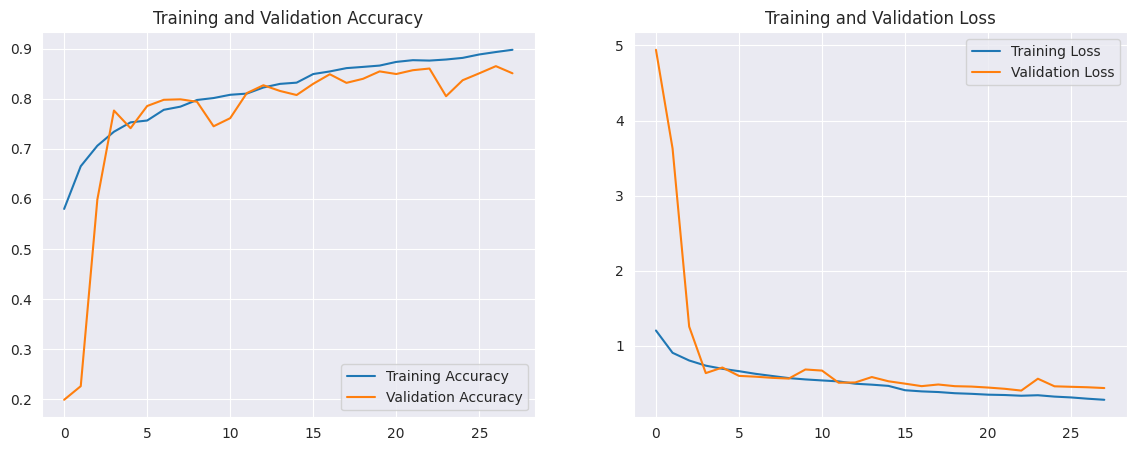

In [17]:
# Fungsi bantu untuk plot
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Panggil fungsi plot
plot_training(history)

## Evaluasi dan Visualisasi

In [18]:
# Evaluasi model menggunakan test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'\nTest Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8507 - loss: 0.3993

Test Accuracy: 85.04%
Test Loss: 0.4215


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


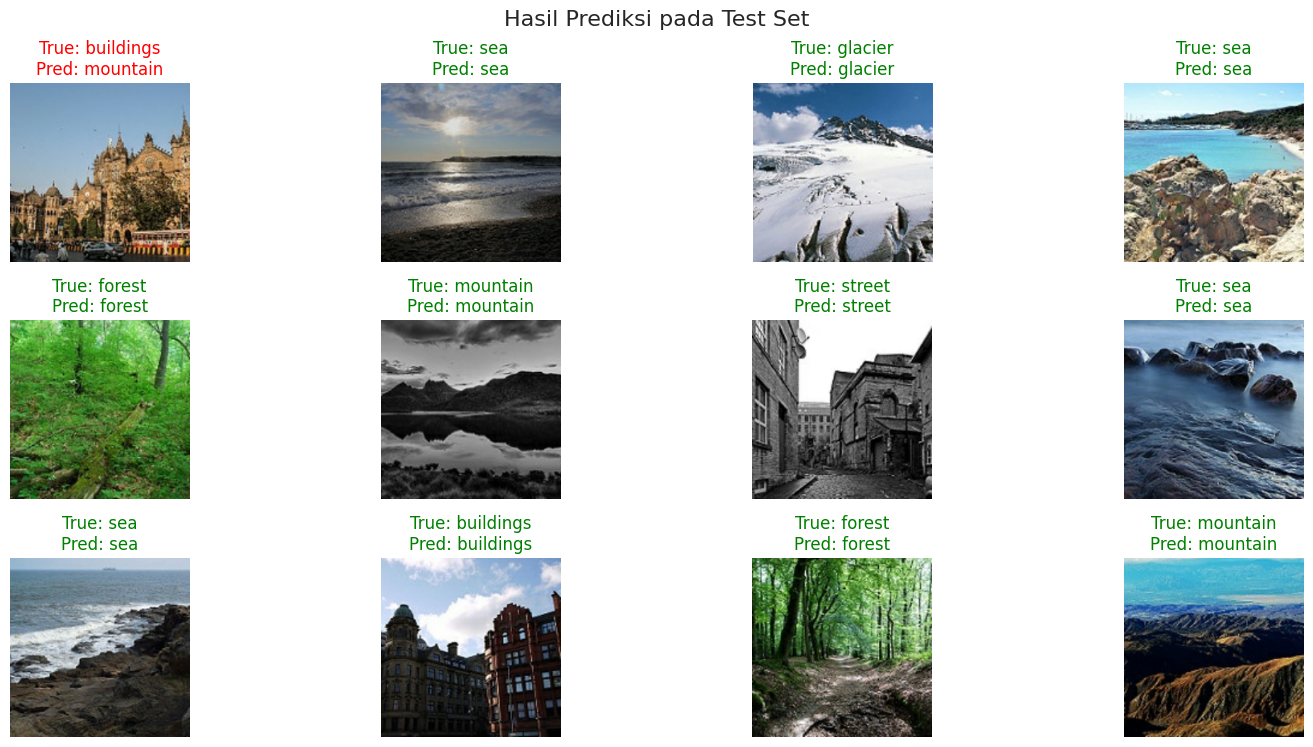

In [19]:
# Ambil 1 batch dari test_ds
plt.figure(figsize=(15, 10))
for images, labels in test_ds.take(1):
    # Prediksi
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Tampilkan 12 gambar pertama
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]

        color = "green" if predicted_labels[i] == labels[i] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")

plt.suptitle("Hasil Prediksi pada Test Set", fontsize=16)
plt.tight_layout()
plt.show()


## Konversi Model

### SavedModel

In [20]:
model.export('saved_model_format')  # simpan sebagai SavedModel
!zip -r saved_model_format.zip saved_model_format  # kompres folder
from google.colab import files
files.download("saved_model_format.zip")  # download zip

Saved artifact at 'saved_model_format'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140276093056784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276093058896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276093058128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276094812816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276093057936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276093058704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276094813776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276094814352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276094815120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140276094813200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1402760948

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF Lite

In [21]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_format")
tflite_model = converter.convert()

# Simpan ke file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Download TFLite
files.download("model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TensorFlow.js

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [24]:
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model_format tfjs_model

# Kompres dan download
!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

2025-05-01 10:19:59.701311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746094799.721629   35975 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746094799.727813   35975 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-01 10:20:09.606424: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746094809.606665   35975 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### requirements.txt

In [25]:
!pip freeze > requirements.txt
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

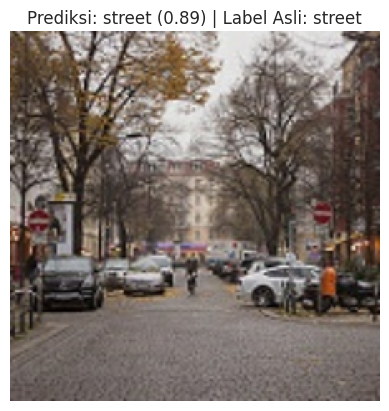

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import TFSMLayer

# Load inference layer dari model saved_model format
inference_layer = TFSMLayer("saved_model_format", call_endpoint="serving_default")

# Ambil satu batch dari validation dataset
for images, labels in val_ds.take(1):
    test_img = images[0]
    true_label = labels[0].numpy()

# Siapkan gambar untuk inference
input_img = tf.expand_dims(test_img, axis=0)  # Tambahkan batch dimensi

# Jalankan inference
raw_output = inference_layer(input_img)
# Karena output berupa dict, ambil nilai prediksi dari dictionary
pred = list(raw_output.values())[0].numpy()

# Interpretasi hasil prediksi
predicted_index = np.argmax(pred)
predicted_class = class_names[predicted_index]
confidence = np.max(pred)

# Tampilkan gambar dengan hasil prediksi
img_to_show = test_img.numpy()
if img_to_show.max() > 1.0:
    img_to_show = img_to_show / 255.0  # Pastikan dalam skala 0-1 agar tidak hitam

plt.imshow(img_to_show)
plt.title(f"Prediksi: {predicted_class} ({confidence:.2f}) | Label Asli: {class_names[true_label]}")
plt.axis('off')
plt.show()
